In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

In [263]:
class Perceptron:
    def __init__(self, eta=0.01, n_iter=10): # eta : learning rate
        self.eta    = eta
        self.n_iter = n_iter
    
    def fit(self, X, y): # X: data matrix, y: target values
        n_rows, n_factors = X.shape
        self.weights = np.zeros(n_factors + 1)
        self.errors = [] # keep track of error count per iter
        
        for i in range(self.n_iter):
            error_count = 0 
            for row, target in zip(X, y): # zip matches each row with the target_value
                update = self.eta * (target - self.predict(row)) # when the prediction and target match, the elem in update is 0; otherwise update causes the weights to move in the opposite direction of the prediction                
                self.weights += update * np.insert(row, 0, 1) # add 1 to the front of row, so that the constant also gets updated # syntax: np.insert(array, index, same_type_values_to_be_inserted) => vector (matrix will be flattened)
                error_count += int(update != 0) # increment error count if prediction is wrong
            self.errors.append(error_count)
        return self
    
    # return 1 or -1
    def predict(self, row):
        return np.where(self.net_input(row) >= 0, 1, -1) # syntax: np.where(cond, value_when_true, value_when_false) => array; if net > 0, assign positive class
    
    # returns a float value
    def net_input(self, row):
        return np.dot(row, self.weights[1:]) + self.weights[0] # dot product plus constant
        

In [129]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df.columns = ['sepal_length','sepal_width', 'petal_length','petal_width', 'class'] # or set names = ['a','b','c','d','e'] when creating df
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


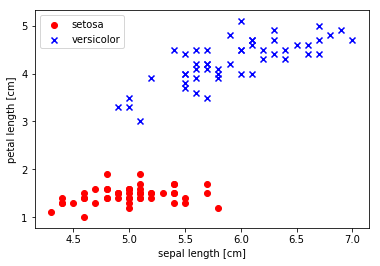

In [387]:
test_data = df.iloc[0:100] # syntax: iloc for accessing by index, loc by accessing by values - which can be set by pd.set_index, pd.set_headers
X = test_data.iloc[:,[0,2]].values # values return array instead of dataframe
y = np.where(df.iloc[:, 4] == 'Iris-setosa', -1, 1) 
# plt.scatter(X[:50, 0], X[:50, 1])
#test_data[test_data['class_name'] == 'iris-virginia'].plot.scatter('sepal_width', 'sepal_length')

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

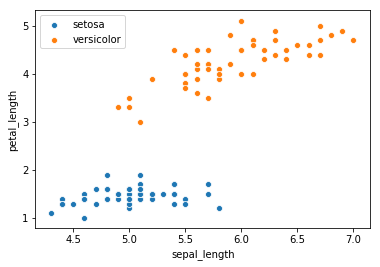

In [260]:
# another way to generate more natively
import seaborn as sns
sns.scatterplot(df.iloc[:50,].sepal_length, df.iloc[:50,].petal_length, label='setosa')
sns.scatterplot(df.iloc[50:100,].sepal_length, df.iloc[50:100,].petal_length, label='versicolor')

In [374]:
# add shuffle
limited_df = df.iloc[:100,].sample(frac=1)
y = np.where(limited_df.iloc[:, 4] == 'Iris-setosa', -1, 1) 
X = limited_df.iloc[:, [0,2]].values

ppn = Perceptron(eta=0.1)
ppn.fit(X,y)

In [375]:
errors = ppn.errors

Text(0,0.5,'errors')

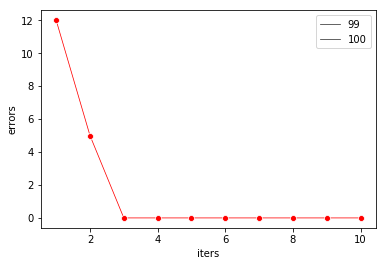

In [376]:
sns.lineplot(range(1, 11), errors, marker='o', color='red', size=100)
plt.xlabel('iters')
plt.ylabel('errors')

In [378]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution = 0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))]) # num of unique classes
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # min & max value of att1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # min & max value of att2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                     np.arange(x2_min, x2_max, resolution))  # np.arrange generates array with evenly space intervals np.arange(min, max, interval)
    dots = np.array([xx1.ravel(), xx2.ravel()]).T # Note: ravel does not copy the values, thus update will alter the origial matrix, but its performace is better than flatten
    # with meshgrid, ravel and transforms, coords of a rectangular set of dots are generated

    Z = classifier.predict(dots) # mark each dot as 1 or -1 depending on the prediction
    Z = Z.reshape(xx1.shape) # since the dots array are flattened, this reshapes it make to a matrix of dots
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

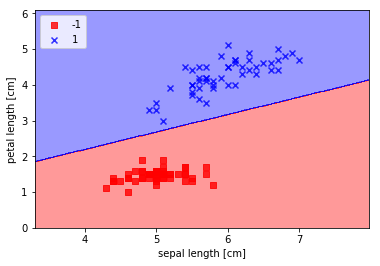

In [379]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [388]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        n_rows, n_factors = X.shape
        self.weights = np.zeros(n_factors + 1)
        self.costs = [] # keep track of cost per iter
        
        for i in range(self.n_iter):
            output = self.net_input(X) # all_predictions
            errors = y - output
            # instead of looping through each row, update weight with result of all rows
            self.weights[1:] += self.eta * X.T.dot(errors) 
            self.weights[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0 # cost fuction: sum of square means / 2
            self.costs.append(cost)
        return self
    
    # return 1 or -1
    def predict(self, X):
        return np.where(self.activation(X) >= 0, 1, -1) # syntax: np.where(cond, value_when_true, value_when_false) => array; if net > 0, assign positive class
    
    def activation(self, X):
        return self.net_input(X)
    
    # returns a float value
    def net_input(self, X):
        return np.dot(X, self.weights[1:]) + self.weights[0] # dot product plus constant

SyntaxError: invalid syntax (<ipython-input-388-d3b1bab98eba>, line 3)